In [1]:
import xarray as xr
from pathlib import Path
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

import splitting_isca_data as sid

# Import data

In [2]:
path = '/home/links/ct715/data_storage/isca/held-suarez'
exp_list = ['HS_T21_100y-nc', 'HS_T42_100y-nc', 'HS_T63_100y-nc', 'HS_T85_100y-nc']

datasets = {}
for exp in exp_list:
    
    nc_path = Path(path) / exp
    # nc_files = list(nc_path.glob('*.nc'))
    nc_files = nc_path.glob('*.nc')
    
    ds = xr.open_mfdataset(
        nc_files,
        parallel=True,
        chunks={'time': 360}
    )
    
    ds_seasonal = sid.seasonal_mean_datasets(ds)
    datasets[exp] = ds_seasonal.load()

## Subset data

### 24 sets of 33 years

In [3]:
split_3way = {
    'set1': slice('2000-12', '2033-09'),
    'set2': slice('2033-12', '2066-09'),
    'set3': slice('2066-12', '2099-09')
}
split_half = {
    'set1': slice('2000-12', '2049-09'),
    'set2': slice('2049-12', '2098-09')
}
split_full = {
    'set1': slice('2000-12', '2099-09')
}

efp_HS = {}
for key, data in datasets.items():
    
    # split name for var saving
    key_splits = key.split('_')[:2]
    exp_name = f'{key_splits[0]}_{key_splits[1]}'
    
    # calculate EFP for various splits of data
    efp_HS[f'{exp_name}_24sets'] = sid.split_and_process_data(data, split_3way)
    efp_HS[f'{exp_name}_16sets'] = sid.split_and_process_data(data, split_half)
    efp_HS[f'{exp_name}_8sets'] = sid.split_and_process_data(data, split_full)
    


# Seaborn boxplot

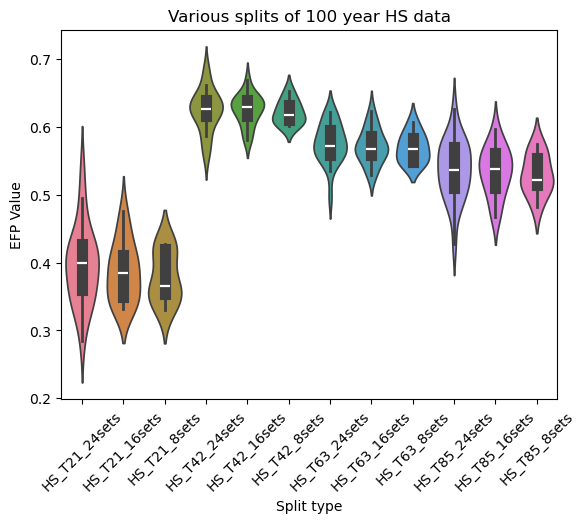

In [4]:
plt.figure()
sns.violinplot(
    data=efp_HS,
    inner_kws=dict(box_width=8, whis_width=2)
)
plt.title('Various splits of 100 year HS data')
plt.xlabel('Split type')
plt.xticks(rotation=45)
plt.ylabel('EFP Value')
plt.show()

***

# Bootstrapping

In [5]:
for key, data in efp_HS.items():
    
    # key_split = key.split('_')
    # exp_name = f'{key_split[0]}_{key_split[1]}'
    # print(exp_name)
    
    print(key)
    sid.print_bootstrap_stats(efp_HS[key])
    print('\n')

HS_T21_24sets
Original Mean: 0.40
Bootstrap Mean: 0.40
95% Confidence Interval: [0.37444969 0.4192051 ]


HS_T21_16sets
Original Mean: 0.39
Bootstrap Mean: 0.39
95% Confidence Interval: [0.36676156 0.4086625 ]


HS_T21_8sets
Original Mean: 0.38
Bootstrap Mean: 0.38
95% Confidence Interval: [0.35492406 0.4037375 ]


HS_T42_24sets
Original Mean: 0.62
Bootstrap Mean: 0.62
95% Confidence Interval: [0.6115124  0.63624635]


HS_T42_16sets
Original Mean: 0.63
Bootstrap Mean: 0.63
95% Confidence Interval: [0.61414359 0.63566875]


HS_T42_8sets
Original Mean: 0.62
Bootstrap Mean: 0.62
95% Confidence Interval: [0.61108719 0.6338375 ]


HS_T63_24sets
Original Mean: 0.58
Bootstrap Mean: 0.58
95% Confidence Interval: [0.5644875  0.58765844]


HS_T63_16sets
Original Mean: 0.57
Bootstrap Mean: 0.57
95% Confidence Interval: [0.56028125 0.58431266]


HS_T63_8sets
Original Mean: 0.57
Bootstrap Mean: 0.57
95% Confidence Interval: [0.5565625 0.58385  ]


HS_T85_24sets
Original Mean: 0.54
Bootstrap Mean: 0